---
# 🔀 **Scalable data processing in the Cloud with DASK**

##### 🔶 This notebook introduces `dask`, a Python library for parallel and distributed computing. `dask` allows to scale up your Python code and data processing workflows to handle larger-than-memory datasets and leverage multiple cores. With the help of `dask`, you can easily scale a wide array of solutions and configure your project to use most of the available computational power. It helps developers scale their entire Python ecosystem, and it can work with your laptop or a container cluster. The best part is that you don’t need to rewrite your entire codebase, you just have to enable parallel computing with minimal modifications based on your use cases.

##### **Below are the key advantages of using `dask`. It can,**
- run your code in parallel on single machine/mutiple cores/cluster of machines.

- handle larger than memory datasets to process and analyze them efficiently.

- integrate seamlessly with popular Python libraries like NumPy, Pandas, and scikit-learn

- use a dynamic task scheduler to manage and optimize the execution of code

- collect the results from the executed tasks and combines them to produce the final output


<img src="https://docs.2i2c.org/_images/scalable_research_hub.png" alt="DASKscaling" width="650"/> 

##### **🎯 Learning objectives:**
1. Using directed graphs discover how to parallelize your existing geophysical research workflow

2. Few basic concepts on `dask` array and dataframe

3. Implement parallelism to your existing workflow using `dask.delayed`

3. Deploy `dask` in the cloud to download and analyze the GNSS data

*Below is a simplified overview of `dask` architecture ⤵️*

***Scheduler ↔ Workers ↔ Client***

<img src="https://user-images.githubusercontent.com/306380/129031260-ad9600b0-1942-40ad-99a7-694ea2d3a382.jpg" alt="DASK" width="650"/> 

---

### **1. Workflow Parallelization**

##### **🚩🚩 📝 EXERCISE**

Before executing your computation you might consider visualizing your task graph. By looking at the inter-connectedness of tasks you can learn more about potential bottlenecks where parallelism may not be possible, or areas where many tasks depend on each other.

In the next part, you need to make your workflows from `intro.ipynb` notebook with directed acyclical graphs (DAGs), which are a type of graph where nodes are linked by one-way connections that do not form any cycles. DAGs are used to illustrate dependencies and causal relationships. This will help you to understand the DASK workflow in more details. The code is already set-up, you just need to tweak the details.

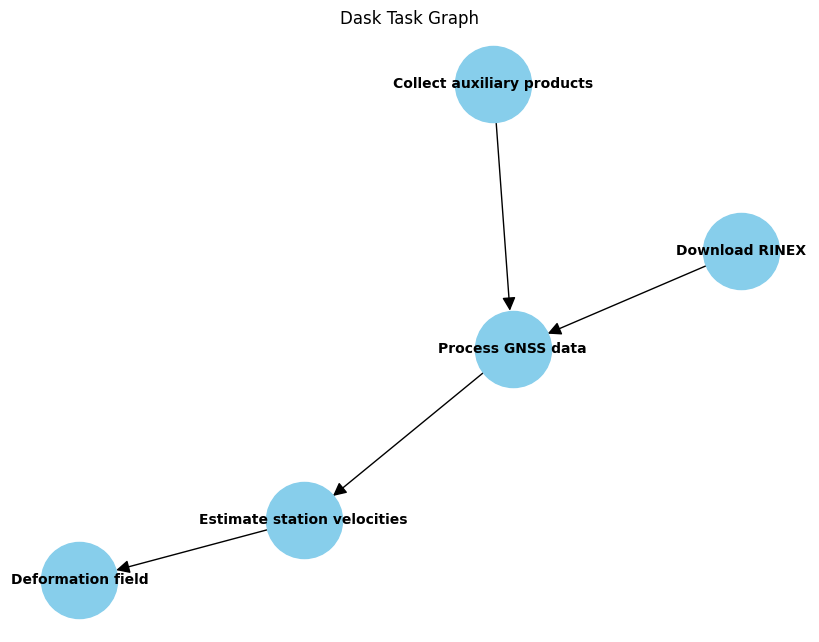

In [20]:
import time
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Divide your workflow into different tasks
Task1 = 'Download RINEX'                    # Grab daily RINEX files for your network of stations.
Task2 = 'Collect auxiliary products'        # Fetch precise satellite ephemerides/clocks and local meteorological data needed for tropospheric corrections
Task3 = 'Process GNSS data'                 # Run your GNSS analysis software (e.g. GAMIT/GLOBK or GIPSY) to do quality control, cycle‐slip repair and compute daily station coordinates.
Task4 = 'Estimate station velocities'       # Fit the coordinate time series to extract long‐term trends (velocities), model seasonal signals, and characterize noise
Task5 = 'Deformation field'                 # Combine station velocities into a vector‐map of horizontal motion, interpret in terms of plate boundaries, strain accumulation, etc.

# Add nodes for tasks
G.add_node(Task1) # Grab daily RINEX files for your network of stations.
G.add_node(Task2)         
G.add_node(Task3)
G.add_node(Task4)
G.add_node(Task5)
# Add edges to show dependencies
G.add_edges_from([(Task1, Task3), (Task2, Task3), (Task3, Task4), (Task4, Task5)])

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)

# Add title and labels
plt.title("Dask Task Graph")
plt.xlabel("Task Dependencies")
plt.ylabel("Execution Flow")

# Show the plot
plt.show()

***

### **2. DASK Array and Dataframe**

##### **array**

Dask array represents a large, potentially out-of-core, multi-dimensional array composed of many smaller `numpy` arrays (called ***chunks***) arranged in a grid.

With `dask` arrays,
- operations build a task graph rather than executing immediately

- computation is expressed in terms of chunkwise `numpy` operations

- can run on a single machine with multiple cores or accross a cluster


In [ ]:
## EXAMPLE CODE SNIPPET
import dask.array as da

# Create a 1000000×1000000 array of zeros, broken into 1000×1000 chunks
x = da.zeros((1000000, 1000000), chunks=(1000, 1000))
y = x + 5          # builds a task graph, no computation yet
result = y.mean()  # also lazy
result.compute()   # actual parallel execution

##### **dataframe**

Dask dataframe is a large table of data composed of many smaller pandas DataFrames (partitions), split along the index.

`dask` dataframe

- implements a large subset of the `pandas` DataFrame interface

- operations are carried out on each pandas partition in parallel

- can handle datasets that exceed RAM by streaming partitions

In [ ]:
## EXAMPLE CODE SNIPPET
import dask.dataframe as dd

# Read a collection of CSV files (~100 GB total) as one Dask DataFrame
df = dd.read_csv('data/large-*.csv')
# Lazy filter and groupby
filtered = df[df.amount > 0]
summary  = filtered.groupby('category').amount.sum()
# Trigger computation
summary.compute()

***

### **3. DASK delayed: parallelizing your workflow**

Sometimes problems don't fit into one of the collections like `dask.array` or `dask.dataframe`. In these cases, one can parallelize custom algorithms using simpler `dask.delayed` interface.

##### **🚩🚩 📝 EXERCISE**

We’ve defined a simple function called `random_sum` that generates 10 random integers and adds them together one by one in a loop. You can think of this function as a stand-in for any generic computation a task might perform.

In the DAG from section 1, some tasks can run in parallel, while others must wait for dependent tasks to finish. Here’s how we’ll simulate that:

- If a task has no dependencies, we’ll simply assign it `random_sum()`.
- If a task depends on others, we’ll assume it takes its own `random_sum()` plus the results from the tasks it depends on.
For example, if `task_3` depends on `task_1` and `task_2`, then:
```
task_3 = random_sum() + task_1 + task_2
```

**Q1: Serial execution**

First, calculate the total time required to complete all tasks without any parallelization. This means running one task after another, in sequence.

**Q2: Parallel execution with dask**

Next, let’s enable parallelization using Dask. Uncomment the `@dask.delayed` decorator above the `random_sum` function. This tells Dask to treat it as a lazy task—it won’t run immediately but will instead build a task graph. Your goal is to compare the total execution time with and without Dask’s parallelization to see the performance benefit.



In [32]:
%%time
# simple function that generates 10 random integers (between 1 and 100) and 
# adds them one by one in a loop, printing the cumulative sum at each step.
import random
import dask

@dask.delayed

def random_sum(n = 100):
    """
    Generates `n` random integers between 1 and 100,
    adds them one by one in a loop, and prints the cumulative sum at each step.
    Returns the final total sum.
    """
    total = 0
    for i in range(n):
        num = random.randint(1, 100)
        total += num
    return total

# ============================================== #


task_1 = random_sum()
task_2 = random_sum()
task_3 = random_sum() + task_1 + task_2
task_4 = random_sum() + task_3
task_5 = random_sum() + task_4

# for serial calc.
'''
print(f"task_1: {task_1}")
print(f"task_2: {task_2}")
print(f"task_3: {task_3}")
print(f"task_4: {task_4}")
print(f"task_5: {task_5}")
'''
# for dask
print(f"task_1: {task_1.compute()}")
print(f"task_2: {task_2.compute()}")
print(f"task_3: {task_3.compute()}")
print(f"task_4: {task_4.compute()}")
print(f"task_5: {task_5.compute()}")
#'''

task_1: 5079
task_2: 5252
task_3: 15946
task_4: 19702
task_5: 25248
CPU times: user 6.18 ms, sys: 2.35 ms, total: 8.53 ms
Wall time: 6.96 ms


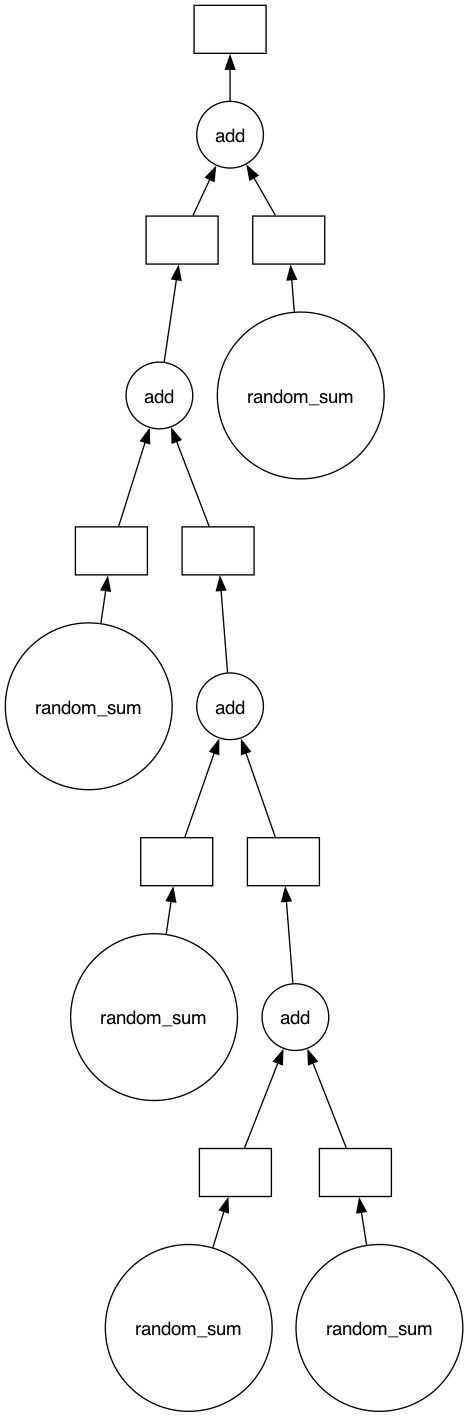

In [ ]:
# Visualize your total task workflow in DAG
task_5.visualize()

***
### **4. Deploy DASK on the cloud**

##### **🚩🚩 📝 EXERCISE**

From the `trad_vs_cloud.ipynb` notebook, build `s3_uri` (to access objects from EarthScope's S3 bucket) and `tdb_config` (onfig dict for TileDB’s S3 virtual filesystem so TileDB knows how to authenticate & parallelize I/O.).


In [ ]:
import dask.dataframe as dd
from dask.distributed import Client


client = Client()
client

# Display the Dask dashboard link
print("Dask dashboard available at:", client.dashboard_link)

In [ ]:
# Get schema and Non-empty domain of Tdb object:
with tiledb.open(uri, mode="r", config=tdb_config,) as A:
    ned=A.nonempty_domain()
    # print(A.schema)

print(start)
start_t = time.time()
# This produces an array slice
def slice_tiledb(path, slc):
    with tiledb.open(uri, mode="r", config=tdb_config,) as A:
        return A[slc,0,:,12611]['snr']
        # return A[slc,:]['snr']
       

# Partition the array into delayed slices
chunk = 43200000*4 # tile size?
delayed_slices = list(
    dask.delayed(slice_tiledb)(uri, slice(int(start), int(start+chunk))) for 
                               start in 
                               np.arange(ned[0][0],ned[0][1]-chunk,step=chunk)) #-86400*1e3

# This creates a Dask array from the delayed slices
darray = dask.array.concatenate(
    dask.array.from_delayed(x,
                            shape=(chunk,), dtype=np.float64)
                            for x in delayed_slices)

#Everything up until here is lazy - nothing is really computed

# This triggers the entire computation
# print(darray.compute_chunk_sizes())
darray.persist()
gw_cluster = darray.mean().compute()

end_t = time.time()
gw_cluster_t=end_t - start_t

print('Object start date: ',utc_time(ned[0][0]))
print('Object end date: ',utc_time(ned[0][1]))

days_p=(ned[0][1]-ned[0][0])/(86400e3)
print('Processing %.01f days took %.01f seconds' %(days_p,gw_cluster_t))

fig, ax = plt.subplots(figsize=(8,4))
plt.bar(["Download and process: in GeoLab",
        "S3 and process: in GeoLab","Dask-Gateway in GeoLab"],
        [9,50,440])
plt.title("Amount of Days of GNSS Data Processed in about 30 seconds")
plt.xticks(rotation=90)
plt.show()